In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# 加载数据
df_Ballycotton = pd.read_csv("./dataProcessed/IrishNationalTideGaugeNetwork_Ballycotton Harbour2017.csv",encoding = "utf-8",)
# 转化为时间序列
df_Ballycotton['time'] = pd.to_datetime(df_Ballycotton['time'])
# 设置时间索引
df_Ballycotton = df_Ballycotton.set_index("time")


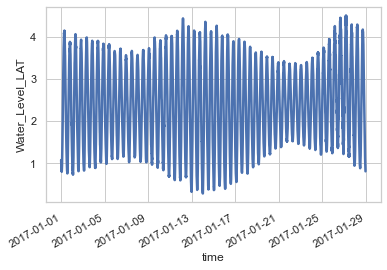

In [15]:
# 画图
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.set_theme(style="whitegrid")
dataPlot = df_Ballycotton.loc["2017-01-01":"2017-01-28","Water_Level_LAT"]
sns.lineplot(data=dataPlot, palette="tab10", linewidth=2.5,ax=ax)
# 将x轴斜过来显示更好看
fig.autofmt_xdate()